<a href="https://colab.research.google.com/github/petwalcharu/eduPath/blob/main/SmartTimetable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colorama matplotlib



University Scheduler
1. Batch Add Tasks
2. View Schedule
3. Suggest Free Slots for New Task
4. Show Gantt-Style Schedule
5. View Faculty Timetable
6. Exit

Enter tasks (type 'done' to finish):

Tasks added and scheduled successfully.

University Scheduler
1. Batch Add Tasks
2. View Schedule
3. Suggest Free Slots for New Task
4. Show Gantt-Style Schedule
5. View Faculty Timetable
6. Exit

Timetable for F3
Wed 7:45-8:40: MFCS Lab 1
Wed 8:40-9:35: MFCS Lab 1
Wed 12:35-1:30: MFCS Lab 2
Wed 1:30-2:25: MFCS Lab 2
Thu 9:50-10:45: MFCS Lab 3
Thu 10:45-11:40: MFCS Lab 3
Fri 7:45-8:40: MFCS Lab 4
Fri 8:40-9:35: MFCS Lab 4
Fri 12:35-1:30: MFCS Lab 5
Fri 1:30-2:25: MFCS Lab 5

University Scheduler
1. Batch Add Tasks
2. View Schedule
3. Suggest Free Slots for New Task
4. Show Gantt-Style Schedule
5. View Faculty Timetable
6. Exit


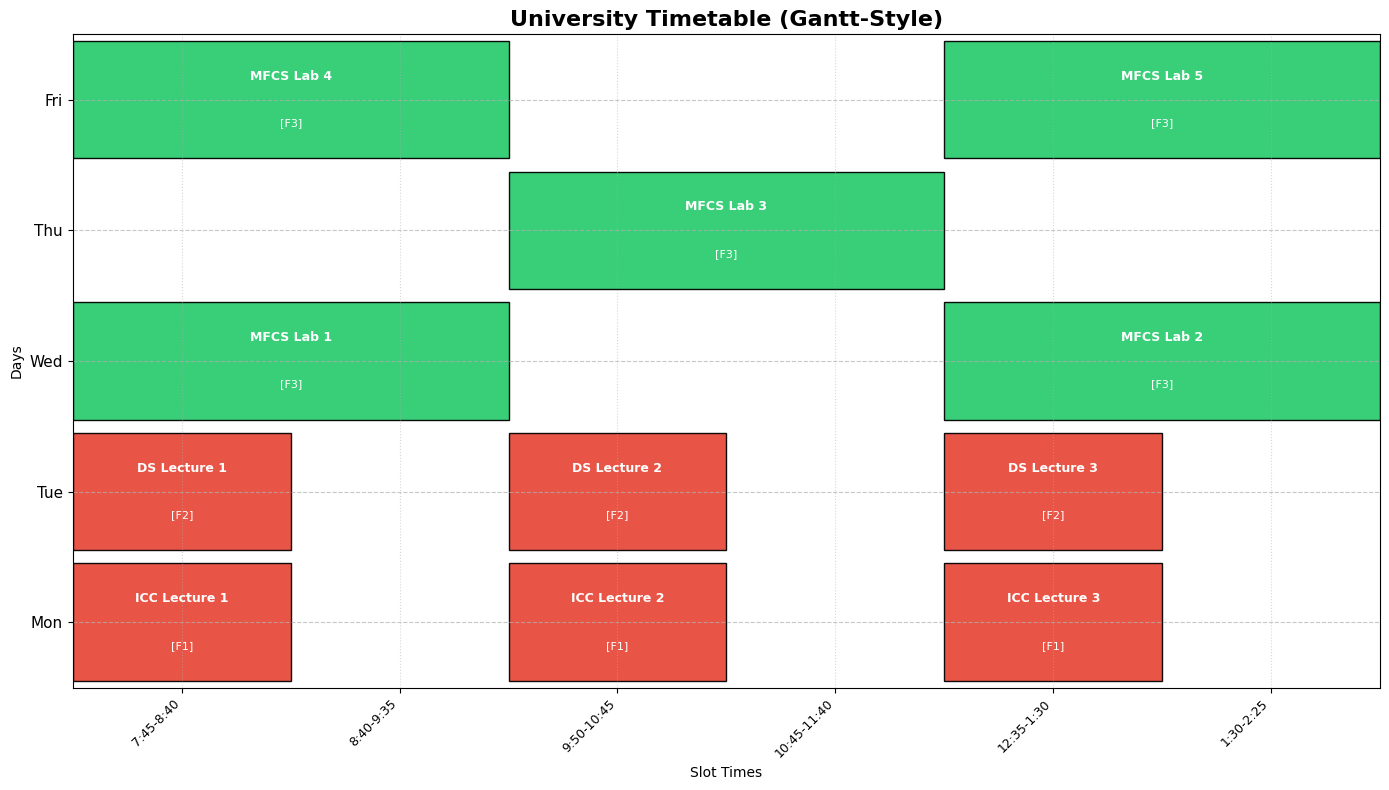


University Scheduler
1. Batch Add Tasks
2. View Schedule
3. Suggest Free Slots for New Task
4. Show Gantt-Style Schedule
5. View Faculty Timetable
6. Exit


In [ ]:
from colorama import Fore, Style, init
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

random.seed(0)
init(autoreset=True)

days = ["Mon", "Tue", "Wed", "Thu", "Fri"]
slot_times = [
    "7:45-8:40", "8:40-9:35",
    "9:50-10:45", "10:45-11:40",
    "12:35-1:30", "1:30-2:25"
]

slot_id_to_time = {}
slot_counter = 1
for day in days:
    for st in slot_times:
        slot_id_to_time[slot_counter] = (day, st)
        slot_counter += 1
MAX_SLOTS = slot_counter - 1

# Valid lab slot blocks (2 consecutive slots)
lab_slot_blocks = []
slots_per_day = len(slot_times)
for day_start_slot in range(1, MAX_SLOTS + 1, slots_per_day):
    lab_slot_blocks.extend([
        [day_start_slot, day_start_slot + 1],
        [day_start_slot + 2, day_start_slot + 3],
        [day_start_slot + 4, day_start_slot + 5]
    ])

category_colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN]
category_color_map = {}

def get_category_color(category):
    if category not in category_color_map:
        category_color_map[category] = category_colors[len(category_color_map) % len(category_colors)]
    return category_color_map[category]

tasks = {}
faculty_availability = {}
schedule = {}
task_counter = 1

type_map = {
    'L': ('Lecture', 1),
    '1': ('Lecture', 1),
    'T': ('Tutorial', 1),
    '2': ('Tutorial', 1),
    'B': ('Lab', 2),
    '3': ('Lab', 2)
}

def assign_slots(tasks, faculty_availability, existing_schedule):
    schedule_local = {}

    # Sort tasks by input order
    all_tasks_to_schedule = {**tasks}
    full_sorted_task_ids = sorted(all_tasks_to_schedule.keys(), key=lambda x: int(x[1:]))

    all_occupied_slots = set()

    for task_id in full_sorted_task_ids:
        info = all_tasks_to_schedule[task_id]
        task_type = info["type"].lower()
        faculty = info["faculty"]
        category = info["category"]

        if task_type == "lab":
            possible_blocks = lab_slot_blocks
        else:
            possible_blocks = [[i] for i in range(1, MAX_SLOTS + 1)]

        forbidden = set()
        forbidden.update(all_occupied_slots)

        # Avoid faculty/category conflicts with existing schedule
        for other_task, assigned_slots in schedule_local.items():
            other_info = all_tasks_to_schedule[other_task]
            if other_info["faculty"] == faculty or other_info["category"] == category:
                forbidden.update(assigned_slots)

        # Faculty unavailability
        forbidden.update(faculty_availability.get(faculty, []))

        # --- Prevent consecutive same-category slots ---
        for other_task, assigned_slots in schedule_local.items():
            other_info = all_tasks_to_schedule[other_task]
            if other_info["category"] == category:
                for s in assigned_slots:
                    forbidden.add(s + 1)
                    forbidden.add(s - 1)
        # ------------------------------------------------

        assigned = False
        for block in possible_blocks:
            if set(block).isdisjoint(forbidden):
                schedule_local[task_id] = block
                all_occupied_slots.update(block)
                assigned = True
                break

        if not assigned:
            schedule_local[task_id] = []

    return schedule_local


def get_organized_schedule(schedule, tasks, slot_id_to_time, max_slots):
    organized_data = {slot_id: [] for slot_id in range(1, max_slots + 1)}
    for t_id, s in schedule.items():
        if not s:
            continue
        color = get_category_color(tasks[t_id]["category"])
        task_name = tasks[t_id]["name"]
        for slot_id in s:
            organized_data[slot_id].append((color, task_name, t_id))
    return organized_data


def menu():
    global tasks, schedule, task_counter
    while True:
        print("\nUniversity Scheduler")
        print("1. Batch Add Tasks")
        print("2. View Schedule")
        print("3. Suggest Free Slots for New Task")
        print("4. Show Gantt-Style Schedule")
        print("5. View Faculty Timetable")
        print("6. Exit")
        choice = input("Enter choice: ").strip()

        if choice == "1":
            print("\nEnter tasks (type 'done' to finish):")
            while True:
                course_name = input("Course Name (or 'done'): ").strip()
                if course_name.lower() == "done":
                    break

                type_code = input("Type (1/L: Lecture, 2/T: Tutorial, 3/B: Lab): ").strip().upper()
                if type_code not in type_map:
                    print(Fore.RED + "Invalid type code! Try again." + Style.RESET_ALL)
                    continue

                type_name, _ = type_map[type_code]
                faculty = input("Faculty Name: ").strip()
                try:
                    num_sessions = int(input("Number of Sessions: ").strip())
                except ValueError:
                    print(Fore.RED + "Invalid number!" + Style.RESET_ALL)
                    continue

                for i in range(1, num_sessions + 1):
                    task_id = f"T{task_counter}"
                    task_counter += 1
                    session_name = f"{course_name} {type_name} {i}"
                    task_info = {
                        "name": session_name,
                        "category": type_name,
                        "faculty": faculty,
                        "type": type_name.lower(),
                        "session": i
                    }
                    tasks[task_id] = task_info

            schedule = assign_slots(tasks, faculty_availability, schedule)
            print(Fore.GREEN + f"\nTasks added and scheduled successfully." + Style.RESET_ALL)

        elif choice == "2":
            if not schedule:
                print(Fore.RED + "No tasks scheduled yet." + Style.RESET_ALL)
                continue

            print("\nSchedule:")
            printed_tasks = set()
            for slot_id in range(1, MAX_SLOTS + 1):
                day, time = slot_id_to_time[slot_id]
                tasks_in_slot = [t_id for t_id, s in schedule.items() if slot_id in s and t_id not in printed_tasks]
                for t_id in tasks_in_slot:
                    task_info = tasks[t_id]
                    s = schedule[t_id]
                    color = get_category_color(task_info["category"])
                    if task_info["type"] == "lab" and len(s) == 2 and slot_id == s[0]:
                        end_time = slot_id_to_time[s[1]][1].split('-')[1]
                        print(f"{day} {time.split('-')[0]}-{end_time}: {color}{task_info['name']}{Style.RESET_ALL} ({task_info['faculty']})")
                        printed_tasks.add(t_id)
                    elif task_info["type"] != "lab" and len(s) == 1:
                        print(f"{day} {time}: {color}{task_info['name']}{Style.RESET_ALL} ({task_info['faculty']})")
                        printed_tasks.add(t_id)

        elif choice == "3":
            course_name = input("Course Name: ").strip()
            type_code = input("Type (L/T/B or 1/2/3): ").strip().upper()
            if type_code not in type_map:
                print(Fore.RED + "Invalid type code!" + Style.RESET_ALL)
                continue
            type_name, slots_needed = type_map[type_code]
            faculty = input("Faculty Name: ").strip()

            possible_blocks = lab_slot_blocks if type_name.lower() == "lab" else [[i] for i in range(1, MAX_SLOTS + 1)]

            forbidden = set()
            for _, s in schedule.items():
                forbidden.update(s)
            for t_id, s in schedule.items():
                if tasks[t_id]["faculty"] == faculty:
                    forbidden.update(s)
            forbidden.update(faculty_availability.get(faculty, []))

            free_slots = [block for block in possible_blocks if set(block).isdisjoint(forbidden)]

            if free_slots:
                readable_slots = []
                for block in free_slots:
                    if len(block) == 1:
                        day, time = slot_id_to_time[block[0]]
                        readable_slots.append(f"{day} {time} (Slot {block[0]})")
                    else:
                        day, start_time = slot_id_to_time[block[0]]
                        _, end_time = slot_id_to_time[block[1]]
                        readable_slots.append(f"{day} {start_time}-{end_time.split('-')[1]} (Slots {block[0]}-{block[1]})")
                print(Fore.CYAN + f"\nSuggested free slots for '{course_name}' ({faculty}):" + Style.RESET_ALL)
                print('\n'.join(readable_slots))
            else:
                print(Fore.RED + f"\nNo free slots available for '{course_name}'" + Style.RESET_ALL)

        elif choice == "4":
            if not schedule:
                print(Fore.RED + "No tasks scheduled yet." + Style.RESET_ALL)
                continue

            fig, ax = plt.subplots(figsize=(14, 8))
            y_pos_map = {days[i]: i for i in range(len(days))}
            x_pos_map = {slot_times[i]: i for i in range(len(slot_times))}

            color_map = {
                Fore.RED: "#e74c3c", Fore.GREEN: "#2ecc71", Fore.YELLOW: "#f1c40f",
                Fore.BLUE: "#3498db", Fore.MAGENTA: "#9b59b6", Fore.CYAN: "#1abc9c"
            }

            sorted_schedule_items = sorted(schedule.items(), key=lambda item: item[1][0] if item[1] else MAX_SLOTS + 1)

            for t_id, s in sorted_schedule_items:
                if not s:
                    continue
                category = tasks[t_id]["category"]
                task_name = tasks[t_id]["name"]
                faculty_name = tasks[t_id]["faculty"]

                color_name = get_category_color(category)
                plot_color = color_map.get(color_name, "#7f8c8d")

                day, start_time = slot_id_to_time[s[0]]
                day_index = y_pos_map[day]
                x_start = x_pos_map[start_time]
                width = len(s)
                rect_height = 0.9
                y_start = day_index + 0.05

                rect = patches.Rectangle(
                    (x_start, y_start), width, rect_height,
                    facecolor=plot_color, edgecolor='black', linewidth=1, alpha=0.95
                )
                ax.add_patch(rect)

                ax.text(x_start + width / 2, y_start + rect_height * 0.7, task_name,
                        ha='center', va='center', color='white', fontsize=9, fontweight='bold')
                ax.text(x_start + width / 2, y_start + rect_height * 0.3, f"[{faculty_name}]",
                        ha='center', va='center', color='white', fontsize=8)

            ax.set_yticks([i + 0.5 for i in range(len(days))])
            ax.set_yticklabels(days, fontsize=11)
            ax.set_xticks([i + 0.5 for i in range(len(slot_times))])
            ax.set_xticklabels(slot_times, rotation=45, ha='right', fontsize=9)
            ax.set_xlim(0, len(slot_times))
            ax.set_ylim(0, len(days))
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.grid(axis='x', linestyle=':', alpha=0.5)
            ax.set_xlabel("Slot Times")
            ax.set_ylabel("Days")
            ax.set_title(f"University Timetable (Gantt-Style)", fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()

        elif choice == "5":
            faculty_name = input("Enter Faculty Name: ").strip()
            print(f"\nTimetable for {faculty_name}")
            faculty_schedule = {slot: [] for slot in range(1, MAX_SLOTS + 1)}
            for t_id, s in schedule.items():
                if tasks[t_id]["faculty"] == faculty_name:
                    for slot in s:
                        faculty_schedule[slot].append(tasks[t_id]["name"])
            found_tasks = False
            for slot in range(1, MAX_SLOTS + 1):
                if faculty_schedule[slot]:
                    day, time = slot_id_to_time[slot]
                    print(f"{day} {time}: {', '.join(faculty_schedule[slot])}")
                    found_tasks = True
            if not found_tasks and faculty_name not in faculty_availability:
                 print(Fore.YELLOW + "No schedule found and no unavailability recorded for this faculty." + Style.RESET_ALL)
            elif not found_tasks and faculty_name in faculty_availability:
                 print(Fore.YELLOW + f"No tasks assigned. Unavailability: {faculty_availability[faculty_name]}" + Style.RESET_ALL)

        elif choice == "6":
            print("Exiting scheduler. Goodbye!")
            break

        else:
            print(Fore.RED + "Invalid choice!" + Style.RESET_ALL)


faculty_availability = {
    "Dr. Smith": [1, 2],
    "Dr. Johnson": [7, 8]
}

menu()
